# 0. Imports

In this section, necessary libraries are imported. Install the below package if needed.

In [1]:
# !pip install nltk


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

The cell below contains a function that calculates a confusion matrix using sklearn's metrics module and plots the results.

In [5]:
def confusion_mat(actual, predicted, labels):
  confusion_matrix = metrics.confusion_matrix(actual, predicted) 
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
  cm_display.plot()
  plt.xticks(rotation=90)
  plt.show() 

# 1. Data Loading and Further Processing

Below, we load the processed data csv into a pandas dataframe.

In [6]:
race = pd.read_csv("//DATA/Processed/race_data.csv")

In this cell, the head of the dataframe is printed.

In [7]:
race.head

<bound method NDFrame.head of        subreddit_id             author  \
0          t5_2qr1c  Agreeable_Task500   
1          t5_2rfyw         thefumingo   
2          t5_2r81q          joculator   
3          t5_2rfyw       forfactorial   
4          t5_2rfyw         sojuandbbq   
...             ...                ...   
369489     t5_2qr1c          ApacheNDN   
369490     t5_2qr1c   EternityOnDemand   
369491     t5_2r81q    Mace-Window_777   
369492     t5_2rfz1    smell-the-roses   
369493     t5_2r81q      GadgetGod1906   

                                                     body  \
0       Yeah honestly, even as a black person from up ...   
1       The opposite experience here; have rarely foun...   
2       Memphis is the 26th most dangerous city in the...   
3       compare the message from wandering earth 2 and...   
4       If you’re serious or semi-serious you could lo...   
...                                                   ...   
369489                             Tha

While the csv file has been pre-processed, additional pre-processing is applied to the data below. This includes text case lowering and lemmatizing.

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
text = []

def process_text():
  for i in range(0, len(race['cleaned_body'])):
    body = race['cleaned_body'][i].lower().split()
    body = [lemmatizer.lemmatize(word) for word in body if not word in set(stopwords)]
    body = ' '.join(body)
    text.append(body)

  return text


In [9]:
race['lemm_stop'] = process_text()

The below cell returns an index value based on the passed class (Asian, White, Black, Native American).

In [10]:
# Changing categories for the A1CResult attribute
def race_category(x):
    if x == 'Asian':
        return 0
    elif x == 'Black':
        return 1
    elif x == 'White':
        return 2
    else:
        return 3

Values of the race_category are filled in based on the index values returned by the race_category function.

In [11]:
race['race_category'] = race['race'].apply(race_category)

Below we can see how these columns have been updated from the above processing.

In [12]:
print(race['race_category'])
print(race['race'])

0         3
1         0
2         1
3         0
4         0
         ..
369489    3
369490    3
369491    1
369492    2
369493    1
Name: race_category, Length: 369494, dtype: int64
0         Native American
1                   Asian
2                   Black
3                   Asian
4                   Asian
               ...       
369489    Native American
369490    Native American
369491              Black
369492              White
369493              Black
Name: race, Length: 369494, dtype: object


Below, a TfidfVectorizer is applied to the lemm_stop column. The lemm_stop column is a processed version of the raw body of the subreddit posts that includes removing stop words, removing punctuation, and implementing lemmatization. 

In [13]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=200000)
tfidf_race = text_transformer.fit_transform(race['lemm_stop'])

Below, the data and labels (represented by numbers) are assigned to X and Y variables.

In [14]:
X = tfidf_race
Y = race['race_category']

Below we can observe the shape of the input data X.

In [15]:
print(X.shape)

(369494, 40131)


# 2. Experiment #3: Logistic Regression (tfidf only) - Implementation and Results

Below, the data is split into training and testing data based on an 80/20 split.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

This cell creates a multinomial Logistic Regression model that uses a lbfgs solver.

In [17]:
# Initiating LOgistic Regression model
model = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=42, n_jobs=-1)

Below, the model is trained using 4 cross validation splits. Cross validation results are calculated using the cross_val_score module.

In [18]:
# Training using cross validation splits
skf = StratifiedKFold(n_splits=4, shuffle=True)
cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_micro')

CV results for each fold are printed below. We can see that each fold performed at 99% or higher.

In [19]:
print(cv_results)

[0.99228677 0.99242209 0.99202966 0.99247612]


In this cell, the model is trained using the previously initiated training split.

In [20]:
# Training the Logistic Regression model
model.fit(X_train, y_train)

LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=-1,
                   random_state=42)

After the model is trained, we generate predictions for the test split of the data.

In [21]:
# Fetching model predictions on test set using LR
y_pred = model.predict(X_test)

We can see below that the model performs similarly on the test data to how it performed in training on CV splits.

In [22]:
# Test accuracy using LR

model.score(X_test, y_test)

0.9923408977117417

Below we can see some prediction/actual examples.

In [23]:
print("Predictions: ", y_pred[:10])
print("Actual:", "\n", y_test[:10])

Predictions:  [2 1 2 2 3 0 2 0 3 2]
Actual: 
 361870    2
302310    1
98866     2
229198    2
125788    3
249274    0
215718    2
12787     0
5270      3
43293     2
Name: race_category, dtype: int64


In [24]:
# Plotting results using Confusion matrix for LR model
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

In this cell we can observe a visualization of the confusion matrix. The most common missed prediction was predicting White instead of Native American. This occurred 170 times. The most missed prediction were from the White class, where we can see that the model predicted White 362 times when it was actually a different class.

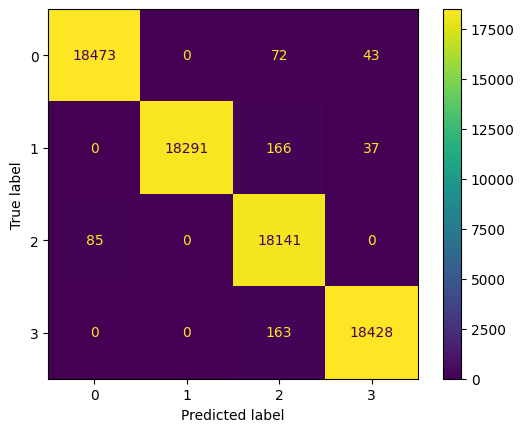

In [25]:
disp.plot()

# 3. Experiment #4: Naive Bayes (tfidf only) - Implementation and Results

Below we create the multinomial naive bayes model and fit it to the training data.

In [26]:
# Implementing Naive Bayes Classifier
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

MultinomialNB()

Then we generate predictions based on the test data.

In [27]:
# Fetching model predictions on test set using NB
y_pred = naive_bayes_model.predict(X_test)

The test accuracy is printed below. We can see it is around 99% just like the LogReg model.

In [28]:
# Test accuracy using NB

naive_bayes_model.score(X_test, y_test)

0.992164981934803

In this cell we can observe a visualization of the confusion matrix.

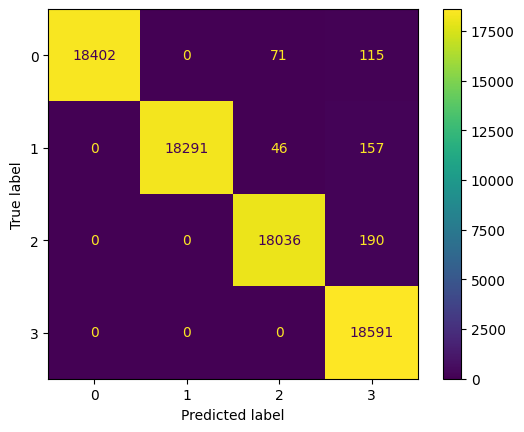

In [29]:
# Plotting results using Confusion matrix for NB model

cm = confusion_matrix(y_test, y_pred, labels=naive_bayes_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=naive_bayes_model.classes_)
disp.plot()

# 4. Experiment #5: Decision Tree (tfidf only) - Implementation and Results

Below we have created a Decision Tree model, fit it to the training data and labels, generated predictions for the test data split, and printed the accuracy as well as visualized a confusion matrix using labels in the respective order of the indexes [0, 1, 2, 3]. The Decision Tree model performed much worse than the LogReg model on the altered input data from Version 1 of each model with an accuracy of only 54%.

Some observations are given below:
* the model developed a huge bias for labelling as Native American and mislabeled many other classes as such.

Train Accuracy:  0.5637849084050813 

Test Accuracy:  0.565677478720957 



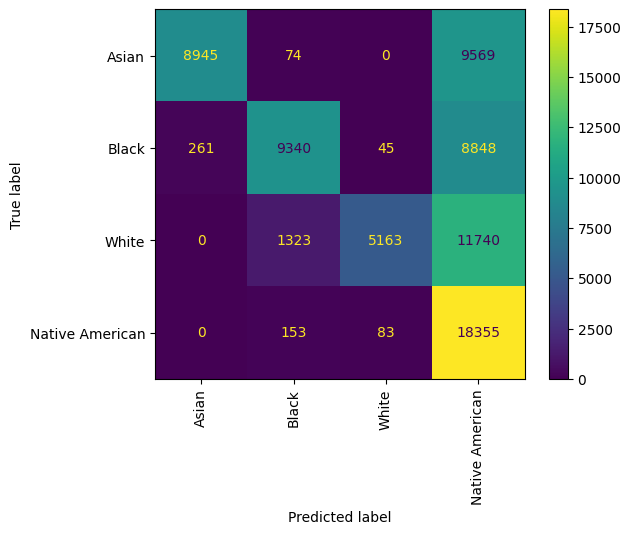

In [31]:
# Decision tree with entropy
decision_tree = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 15, min_samples_leaf = 5)
  
# Performing training
decision_tree.fit(X_train, y_train)

# generate predictions
y_pred = decision_tree.predict(X_test)

print("Train Accuracy: ", decision_tree.score(X_train, y_train), "\n")
print("Test Accuracy: ", metrics.accuracy_score(y_test, y_pred), "\n")

labels = ["Asian", "Black", "White", "Native American"]

# print confusion matrix
confusion_mat(y_test, y_pred, labels)
